# 정확도(Accuracy)

$정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수$

정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표이다. <br>
하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지로 성능을 평가하지 않는다.

정확도 지표가 어떻게 ML 모델의 성능을 왜곡하는지 예제로 살펴본다.

타이타닉 예제 수행 결과를 보면, <br>
ML 알고리즘을 적용한 후 예측 정확도의 결과가 보통 80%대였지만, 탑승객이 남자인 경우보다 여자인 경우에 생존 확률이 높았기 때문에 별다른 알고리즘 적용 없이 무조건 성별이 여자인 경우 생존으로, 남자인 경우 사망으로 예측 결과를 예측해도 이와 비슷한 수치가 나올 수 있다.

단지 성별 조건 하나만을 가지고 결정하는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황이 발생하게 된다.



## 불균형한 레이블 값 분포 / 이진 분류에서 정확도(Accuracy) 사용시 유의할 점

### 예제 1 : [Titanic] 성별에 따른 생존자수 예측 정확도

#### 성별에 따라 생존자를 예측하는 단순한 Classifier

BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성한다.

BaseEstimator를 상속받으면 Customized 형태의 Estimator를 개발자가 생성할 수 있다.

생성할 클래스는 학습을 수행하는 fit() method는 아무것도 수행하지 않으며 예측을 수행하는 predict() method는 단순히 Sex Feature가 1이면 0, 그렇지 않으면 1로 예측하는 단순한 Classifier이다.

In [22]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator) :
    # fit() method는 아무것도 학습하지 않음
    def fit(self, X, y=None) :
        pass 
    
    # predict() method는 단순히 Sex feature가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X) :
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]) :
            if X['Sex'].iloc[i] == 1 :
                pred[i] = 0
            else :
                pred[i] = 1
        return pred

#### MyDummyClassifier를 이용해 앞서 타이타닉 생존자 예측을 수행

데이터를 가공하고 나서 이 Classifier를 이용해 학습/예측/평가 진행

In [23]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df) :
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# ML Algorithm에 불필요한 Feature 제거
def drop_features(df) :
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df) :
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features :
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 데이터 전처리 함수 호출
def transform_features(df) :
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도 : {0: .4f}" .format(accuracy_score(y_test, mypredictions)))


Dummy Classifier의 정확도 :  0.7877


#### 결과

: 이렇게 단순한 알고리즘으로 예측을 하더라도 데이터 구성에 따라 정확도 결과는 약 78.77%로 <br>
꽤 높은 수치가 나올 수 있기 때문에 정확도를 평가 지표롤 사용할 때는 매우 신중해야 한다.

특히 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 평가할 경우, 적합한 평가 지표가 아니다. <br>
( 예를 들어 100개의 데이터가 있고 이 중에 90개의 데이터 레이블이 0, 단 10개의 데이터 레이블이 1이라고 한다면 <br>
무조건 0으로 예측 결과를 반환하는 ML 모델의 경우라도 정확도가 90%가 되기 때문이다. )



### 예제 2 : [MNIST] binary classification으로 변경 후 정확도 측정

MNIST 데이터셋을 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴본다.

MNIST 데이터셋은 0~9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, <br>
이를 기반으로 숫자 Digit을 예측하는 데 사용된다.

`원래 MNIST 데이터셋은 레이블 값이 0부터 9까지 있는 Multi Label 분류를 위한 것 `인데, 이것을 `레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 살짝 바꿔` 보겠다.

`즉, 전체 데이터의 10%만 True, 나머지 90%는 False인 불균형 데이터셋으로 변형하는 것이다.`

In [25]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator) :
    def fit(self, X, y) :
        pass 

    # 입력값으로 들어오는 X 데이터셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X) :
        return np.zeros( (len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터셋인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 그렇지 않으면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=1)

In [26]:
# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트셋 크기 : ", y_test.shape)
print("테스트셋 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여 정확도는 : {0: .3f}" .format(accuracy_score(y_test, fakepred)))

레이블 테스트셋 크기 :  (450,)
테스트셋 레이블 0과 1의 분포도
0    402
1     48
dtype: int64
모든 예측을 0으로 하여 정확도는 :  0.893


#### 결과

단순히 predict()의 결과를 np.zeros()로 모두 0값으로 반환됨에도 불구하고 450개의 테스트 데이터셋에 수행한 예측 정확도는 90%이다.

단지 모든 것을 0으로만 예측해도 MyFakeClassifier의 정확도가 90%로 유수의 ML 알고리즘과 비슷한 성능을 갖는 말도 안되는 결과이다.

`이처럼 정확도 평가 지표는 불균형한 레이블 데이터셋에서는 성능 수치로 사용돼서는 안된다.
정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용하여 ML 모델 성능을 평가해야 한다.`

이를 위해 `오차 행렬(Confusion Matrix)`가 있다.


# 오차행렬(Confusion Matrix)

이진 분류에서 성능 지표로 잘 활용되는 오차행렬은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표이다.

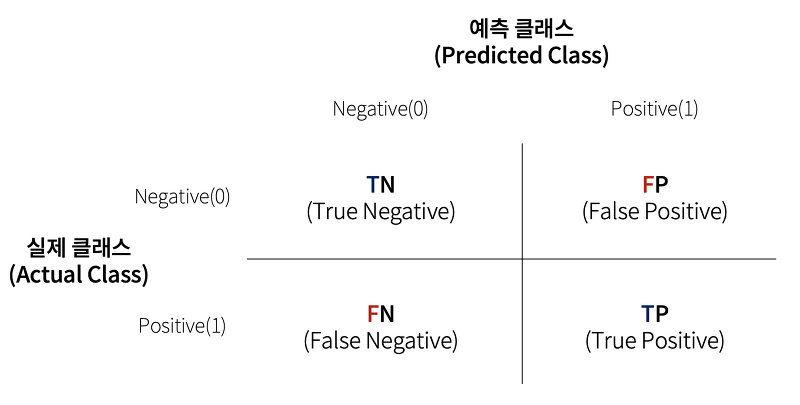

* TN : 예측값 0, 실제값 0
* FP : 예측값 1, 실제값 0
* FN : 예측값 0, 실제값 1
* TP : 예측값 1, 실제값 1

사이킷런은 오차 행렬을 위해 `confusion_matrix()` API 제공.


## confusion_matrix()
정확도(Accuracy) 예제에서 다룬 MyFakeClassifier의 예측 결과인 fakepred와 실제 결과인 y_test를 confusion_matrix()의 인자로 입력해 오차 행렬을 출력

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

# TN : 402  (예측 : 7 아님, 실제 : 7 아님)
# FP : 0    (예측 : 7 맞음, 실제 : 7 아님)
# FN : 45   (예측 : 7 아님, 실제 : 7 맞음)
# TP : 0    (예측 : 7 맞음, 실제 : 7 맞음)

array([[402,   0],
       [ 48,   0]])

## 정확도(Accuracy), 정밀도(Precision), 재현율(Recall)
TN, FP, FN, TP 값은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보를 제공.
이 값을 조합하여 `정확도(Accuracy)`, `정밀도(Precision)`, `재현율(Recall)` 값을 알 수 있음.

$정확도(Accuracy) = (TN + TP) / (TN + FP + FN + TP) = (예측값과 실제값이 동일한 건수)/(모든 데이터 수)$

$정밀도(Precision) = TP / (FP + TP) = (예측값과 실제값이 Positive로 동일한 건수) / (예측값이 Positive인 모든 데이터 수)$

$재현율(Recall) = TP / (FN + TP) = (예측값과 실제값이 Psotivie로 동일한 건수) / (Positive인 모든 데이터 건수)$

`정확도`는 불균형한 이진 분류 데이터셋에서는 Positivie 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Negative로 예측 정확도가 높아지는 경향이 발생한다.<br>
만약 10,000건의 데이터셋에서 9,900건이 Negative이고 100건이 Positive라면 Negative로 예측하는 경향이 더 강해서 TN은 매우 커지고 TP는 매우 작아지게 된다. <br>
또한 Negative로 예측할 때 정확도가 높기 때문에 FN이 매우 작고,<br>
Positive로 예측할 때 정확도가 낮기 때문에 FP 역시 매우 작아진다.

결과적으로 비대칭한 데이터셋에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적 판단 오류를 일으키게 된다.

`정밀도와 재현율`은 데이터셋의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.
앞서 만든 MyFakeClassifer는 Positive로 예측한 TP값이 하나도 없기 때문에 정밀도와 재현율 값 모두 0이다. <br>

`정밀도`는 예측을 Positive한 대상 중에서 예측과 실제값이 Positive로 일치한 데이터의 비율을 뜻한다. Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 `양성 예측도`라고도 불린다.<br>
정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative인 데이터 예측을 Positve로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우. <br>
ex) 스팸메일 여부 판단 모델의 경우, 실제 Negative인 일반 메일을 Positive인 스팸 메일로 분류할 경우에는 메일을 아예 받지 못하게 돼 업무에 차질이 생김.

`재현율`은 실제 값이 Positive인 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율을 뜻한다. `민감도(Seneitivity) 또는 TPR(True Positive Rate)`라고도 불린다.<br>
재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우.
ex) 보험 사기와 같은 금융 사기 적발 모델의 경우, 실제 금융 사기인 Positive건을 Negative로 판단하게 되면 회사에 미치는 손해가 클 것임. 

가장 좋은 성능 평가는 재현율과 정밀도 `모두` 높은 수치를 얻는 것이다. <br>
둘 중 어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않다.


## precision_score(), recall_score()

precision_score() : 정밀도 계산
recall_score() : 재현율 계산

In [28]:
# confusion_matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 get_clf_eval() 함수 생성

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0: .4f}, 정밀도 : {1: .4f}, 재현율 : {2: .4f}" .format(accuracy, precision, recall))

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 타이타닉 데이터 재로드, 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=20, random_state=11)

# 로지스틱 회귀 기반, 생존자 예측
lr_clf = LogisticRegression(solver='liblinear') # solve='liblinear' : 로지스틱 회귀의 최적화 알고리즘 지정. 데이터셋의 이진 분류인 경우 solver는 liblinear가 성능이 좋은 경향이 있다. solver의 기본값은 lbfgs이며 데이터셋이 상대적으로 크고 다중 분류인 경우 적합.
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[15  0]
 [ 1  4]]
정확도 :  0.9500, 정밀도 :  1.0000, 재현율 :  0.8000
